*** ACCESS TO AND MANIPULATE A POSTGRESQL DATABASE FROM R ***

# 1. Using RPostgreSQL package

First load necessary package

In [1]:
library(RPostgreSQL)

Loading required package: DBI


Load PostgreSQL driver

In [3]:
drvv <- dbDriver("PostgreSQL")
drvv

<PostgreSQLDriver>

Create a connection to a database using the driver

In [4]:
con <- dbConnect(drvv,
                 dbname = "imdb",
                 host = "localhost",
                 port = 5432,
                 user = "postgres",
                 password = "bda505")

con

<PostgreSQLConnection>

Get list of table names

In [6]:
table_names <- dbGetQuery(con,
                          "SELECT table_name
                          FROM information_schema.tables 
                          WHERE table_type = 'BASE TABLE'
                          AND table_schema = 'public'
                          ORDER BY table_name
                          "
                          )

table_names

class(table_names)

table_name
name_basics
title_basics
title_crew
title_episode
title_principals_melt
title_ratings


[1] "data.frame"

Or more easily with:

In [38]:
dbListTables(con)

[1] "title_basics"          "title_crew"            "title_principals_melt"
[4] "title_ratings"         "name_basics"           "title_episode"

Good! The query returns a data frame

Now we can loop through tables to automatize queries

Lets first get row counts of all tables, one by one

In [24]:
# table_names is a data frame
# it is easier to work with and iterate through vectors
# so first extract the vector from the table_names
table_names_vec <- table_names[[1]]

# create a query template that we can change the parameters of
# each "%s" stands for a variable that we will manipulate with sprintf
query_text <- "SELECT count (*) FROM %s"

# create an empty vector, the length of the table names
# we will populate this vector with the row counts from tables
row_counts <- rep(NA, length(table_names_vec))

# update the names of the vector with table names
names(row_counts) <- table_names_vec

# for across table names indices (not the names themselves)
for (tbl_ind in seq_along(table_names_vec))
{
    # replace the %s pointer in query text with table name
    current_query <- sprintf(query_text, table_names_vec[tbl_ind])
    
    # run the query and get results
    table_name <- dbGetQuery(con, current_query)
    
    # assign the query result to vector
    row_counts[tbl_ind] <- table_name[[1]]
}
                  
return(row_counts)

name_basics          title_basics            title_crew 
              8155447               4534354               4534354 
        title_episode title_principals_melt         title_ratings 
              2986925              25358895                767041

In [22]:
row_counts

name_basics          title_basics            title_crew 
              8155447               4534354               4534354 
        title_episode title_principals_melt         title_ratings 
              2986925              25358895                767041

In [23]:
class(row_counts)

[1] "numeric"

Now close the database connection

In [26]:
dbDisconnect(con)

[1] TRUE

Now let's create a copy of the imdb database as imdb2 (so that imdb stays intact)

Open another connection to postgres database, so that we can play with imdb better

In [27]:
con <- dbConnect(drvv,
                 dbname = "postgres",
                 host = "localhost",
                 port = 5432,
                 user = "postgres",
                 password = "bda505")

con

<PostgreSQLConnection>

Kill all connections to imdb database (so that subsequent actions do not yield an error)

In [30]:
dbGetQuery(con,
"
SELECT pg_terminate_backend(pg_stat_activity.pid) FROM pg_stat_activity 
WHERE pg_stat_activity.datname = 'imdb' AND pid <> pg_backend_pid();
"
                          )

<0 x 0 matrix>

Now create a copy of the imdb database as imdb2

In [32]:
dbGetQuery(con,
"
CREATE DATABASE imdb2
WITH TEMPLATE imdb OWNER postgres
TABLESPACE = pg;
"
                          )

Close the connection

In [36]:
dbDisconnect(con)

[1] TRUE

And open a new connection, this time to imdb2 database

In [37]:
con <- dbConnect(drvv,
                 dbname = "imdb",
                 host = "localhost",
                 port = 5432,
                 user = "postgres",
                 password = "bda505")

con

<PostgreSQLConnection>

List tables:

In [40]:
table_names_vec <- dbListTables(con)
table_names_vec
class(table_names_vec)

[1] "title_basics"          "title_crew"            "title_principals_melt"
[4] "title_ratings"         "name_basics"           "title_episode"

[1] "character"

This yields a character vector, not a data frame

Get row counts

In [41]:
# create a query template that we can change the parameters of
# each "%s" stands for a variable that we will manipulate with sprintf
query_text <- "SELECT count (*) FROM %s"

# create an empty vector, the length of the table names
# we will populate this vector with the row counts from tables
row_counts <- rep(NA, length(table_names_vec))

# update the names of the vector with table names
names(row_counts) <- table_names_vec

# for across table names indices (not the names themselves)
for (tbl_ind in seq_along(table_names_vec))
{
    # replace the %s pointer in query text with table name
    current_query <- sprintf(query_text, table_names_vec[tbl_ind])
    
    # run the query and get results
    table_name <- dbGetQuery(con, current_query)
    
    # assign the query result to vector
    row_counts[tbl_ind] <- table_name[[1]]
}
                  
return(row_counts)

title_basics            title_crew title_principals_melt 
              4534354               4534354              25358895 
        title_ratings           name_basics         title_episode 
               767041               8155447               2986925

Let's import a table as a data frame into R

In [80]:
title_basics_df <- dbGetQuery(con, "SELECT * from title_basics")

Get the head, attributes and summary of the data frame

In [81]:
head(title_basics_df)

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
tt0000001,short,Carmencita,Carmencita,FALSE,1894,NA,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,FALSE,1892,NA,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,FALSE,1892,NA,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,FALSE,1892,NA,NA,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,FALSE,1893,NA,1,Short
tt0000006,short,Chinese Opium Den,Chinese Opium Den,FALSE,1894,NA,1,Short


In [82]:
attributes(title_basics_df)

In [83]:
summary(title_basics_df)

    tconst           titletype         primarytitle       originaltitle     
 Length:4534354     Length:4534354     Length:4534354     Length:4534354    
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
  isadult          startyear         endyear        runtimeminutes   
 Mode :logical   Min.   :1874     Min.   :1924      Min.   :     0   
 FALSE:4403403   1st Qu.:1995     1st Qu.:1988      1st Qu.:    15   
 TRUE :130951    Median :2007     Median :2003      Median :    30   
 NA's :0         Mean   :1999     Mean   :1998      Mean   :    47   
                 3rd Qu.:2013     

Now an easier way to read data into R

In [90]:
title_basics_df_b <- dbReadTable(con, "title_basics")

See whether they are identical objects

In [91]:
identical(title_basics_df, title_basics_df_b)

[1] TRUE

So, they are identical

What is the object size of each data frame?

In [92]:
format(object.size(title_basics_df), units = "auto")

[1] "817.6 Mb"

In [93]:
format(object.size(title_basics_df_b), units = "auto")

[1] "817.6 Mb"

They take too much space. Now let's get rid of one of them

In [94]:
rm(title_basics_df_b)

New get the classes of all columns

In [95]:
sapply(title_ratings_df, class)

tconst      titletype   primarytitle  originaltitle        isadult 
   "character"    "character"    "character"    "character"      "logical" 
     startyear        endyear runtimeminutes         genres 
     "integer"      "integer"      "integer"    "character"

Now let's extract a subset of the data frame

Let's say, take rows in which 

name contains "Star Wars",

not an adult movie

title_type is a movie and

start year is between 1977 and 2016

In [115]:
title_basics_df2 <- title_basics_df[
    grepl("(?i)star.*wars", title_basics_df$primarytitle) &
    !title_basics_df$isadult &
    title_basics_df$titletype == "movie" &
    title_basics_df$startyear >= 1977 &
    title_basics_df$startyear <= 2016,
]

In [116]:
title_basics_df2

,tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
75193,tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
79009,tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
84359,tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
118147,tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
118872,tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
118873,tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
372161,tt0387563,movie,Saving Star Wars,Saving 'Star Wars',FALSE,2004,NA,NA,Comedy
448871,tt0466264,movie,The Untitled Star Wars Mockumentary,The Untitled Star Wars Mockumentary,FALSE,2003,NA,45,Comedy
1104619,tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
1147803,tt1185834,movie,Star Wars: The Clone Wars,Star Wars: The Clone Wars,FALSE,2008,NA,98,"Action,Adventure,Animation"


Did not like NA's in tconst, let's enhance it

In [119]:
title_basics_df3 <- title_basics_df2[
    !is.na(title_basics_df2$tconst),
]

In [120]:
title_basics_df3

,tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
75193,tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
79009,tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
84359,tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
118147,tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
118872,tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
118873,tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
372161,tt0387563,movie,Saving Star Wars,Saving 'Star Wars',FALSE,2004,NA,NA,Comedy
448871,tt0466264,movie,The Untitled Star Wars Mockumentary,The Untitled Star Wars Mockumentary,FALSE,2003,NA,45,Comedy
1104619,tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
1147803,tt1185834,movie,Star Wars: The Clone Wars,Star Wars: The Clone Wars,FALSE,2008,NA,98,"Action,Adventure,Animation"


Much better!

Now let's write this data frame into our imdb2 database as a new table

In [122]:
dbWriteTable(con, "star_wars", value = title_basics_df3, append = TRUE, row.names = FALSE)

[1] TRUE

Check whether table is created:

In [136]:
dbExistsTable(con, "star_wars")

[1] TRUE

And read from the database again

In [126]:
star_wars <- dbReadTable(con, "star_wars")

star_wars

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
tt0387563,movie,Saving Star Wars,Saving 'Star Wars',FALSE,2004,NA,NA,Comedy
tt0466264,movie,The Untitled Star Wars Mockumentary,The Untitled Star Wars Mockumentary,FALSE,2003,NA,45,Comedy
tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
tt1185834,movie,Star Wars: The Clone Wars,Star Wars: The Clone Wars,FALSE,2008,NA,98,"Action,Adventure,Animation"


See, the only difference seems to be the rownames which we excluded on purpose

Apart from that, let's check whet they are both identical

In [127]:
rownames(title_basics_df3) <- NULL
title_basics_df3

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
tt0387563,movie,Saving Star Wars,Saving 'Star Wars',FALSE,2004,NA,NA,Comedy
tt0466264,movie,The Untitled Star Wars Mockumentary,The Untitled Star Wars Mockumentary,FALSE,2003,NA,45,Comedy
tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
tt1185834,movie,Star Wars: The Clone Wars,Star Wars: The Clone Wars,FALSE,2008,NA,98,"Action,Adventure,Animation"


In [128]:
identical(title_basics_df3, star_wars)

[1] TRUE

Yes they are identical!

Let's remove the table

In [130]:
dbRemoveTable(con, "star_wars")

[1] TRUE

Check whether it still exists

In [131]:
dbExistsTable(con, "star_wars")

[1] FALSE

Now let's create the table again

In [132]:
dbWriteTable(con, "star_wars", value = title_basics_df3, append = TRUE, row.names = FALSE)

[1] TRUE

Check that it exists:

In [134]:
dbExistsTable(con, "star_wars")

[1] TRUE

Get its rowcount:

In [138]:
dbGetQuery(con, "SELECT count (*) FROM star_wars")

count
22


And repeat the data write statement, with append option

In [139]:
dbWriteTable(con, "star_wars", value = title_basics_df3, append = TRUE, row.names = FALSE)

[1] TRUE

Get the rowcount again

In [140]:
dbGetQuery(con, "SELECT count (*) FROM star_wars")

count
44


<a href="https://www.youtube.com/embed/tsXEToflqGs?start=10&autoplay=1">OW! I HAVE A BAD FEELING ABOUT THIS</a>

We did not define a primary key, so postgresql server allowed duplicates to be inserted in to the database

Now delete and recreate table

In [141]:
dbRemoveTable(con, "star_wars")

[1] TRUE

In [142]:
dbExistsTable(con, "star_wars")

[1] FALSE

In [143]:
dbWriteTable(con, "star_wars", value = title_basics_df3, append = TRUE, row.names = FALSE)

[1] TRUE

In [144]:
dbExistsTable(con, "star_wars")

[1] TRUE

And add a primary key constraint

In [145]:
dbGetQuery(con,           
"
ALTER TABLE star_wars
ADD CONSTRAINT tconst_pk_07 
PRIMARY KEY (tconst);
")

<0 x 0 matrix>

Let's try to import the data again

In [146]:
dbWriteTable(con, "star_wars", value = title_basics_df3, append = TRUE, row.names = FALSE)

ERROR: Error in postgresqlgetResult(new.con): RS-DBI driver: (could not Retrieve the result : ERROR:  duplicate key value violates unique constraint "tconst_pk_07"
DETAIL:  Key (tconst)=(tt0076759) already exists.
CONTEXT:  COPY star_wars, line 1
)


See that:

*** could not Retrieve the result : ERROR:  duplicate key value violates unique constraint "tconst_pk_07 ***

Let's check the row count again:

In [148]:
dbGetQuery(con, "SELECT count (*) FROM star_wars")

count
22


OK, we duplicates were really not allowed!

Let's close connection

In [151]:
dbDisconnect(con)

[1] TRUE

And unload the driver

In [152]:
dbUnloadDriver(drvv)

[1] TRUE

# 2. Using sqldf package

First let's load the package:

In [153]:
library(sqldf)

And set the options:

In [154]:
options(sqldf.RPostgreSQL.user ="postgres", 
  sqldf.RPostgreSQL.password ="bda505",
  sqldf.RPostgreSQL.dbname ="imdb2",
  sqldf.RPostgreSQL.host ="localhost", 
  sqldf.RPostgreSQL.port =5432)

Now let's run a query to get average runtimeminutes from title_basics and group them and order them by startyear  

In [157]:
query = "SELECT avg(runtimeminutes) runtimeminutes, startyear 
            FROM title_basics
            GROUP BY startyear
            ORDER BY startyear;"

av_runtime <- sqldf(query)

In [159]:
av_runtime

class(av_runtime)

runtimeminutes,startyear
NA,1874
1.000000,1878
1.000000,1883
1.000000,1887
0.750000,1888
NA,1889
1.000000,1890
1.000000,1891
2.750000,1892
1.000000,1893


[1] "data.frame"

It returns a data frame

Now subset years between 1940 and 2016

In [163]:
av_runtime_subset <- av_runtime[av_runtime$startyear %in% 1940:2016,]

av_runtime_subset

,runtimeminutes,startyear
57,61.09644,1940
58,57.72449,1941
59,57.48081,1942
60,59.36931,1943
61,56.20810,1944
62,54.21501,1945
63,55.94784,1946
64,59.17606,1947
65,57.52189,1948
66,56.56834,1949


Check whether any NA's exist

In [164]:
which(is.na(av_runtime_subset[[1]]))

integer(0)

Let's plot the data

In [166]:
runtime_ts <- ts(av_runtime_subset[[1]],
                 start = av_runtime_subset[1,2],
                 end = av_runtime_subset[nrow(av_runtime_subset),2])

runtime_ts

Time Series:
Start = 1940 
End = 2016 
Frequency = 1 
 [1] 61.09644 57.72449 57.48081 59.36931 56.20810 54.21501 55.94784 59.17606
 [9] 57.52189 56.56834 56.46205 54.01933 52.11005 49.62463 51.03129 48.87632
[17] 49.58294 48.39597 48.35943 48.62121 48.83042 50.05591 53.80506 52.50573
[25] 52.99213 52.59998 52.05031 52.48186 56.38770 56.10259 59.82178 60.26476
[33] 61.36278 60.89975 60.52990 59.52395 61.76300 64.26495 63.94847 63.89022
[41] 64.12069 64.82314 64.88972 63.27469 61.43913 60.60667 60.98615 61.86920
[49] 61.05390 59.43898 56.91495 57.82830 57.57734 56.34543 56.31242 56.09262
[57] 55.70441 54.02251 55.54887 54.95757 56.50677 54.43055 53.38782 54.22617
[65] 54.40710 51.29821 48.63466 46.76012 44.21039 41.90973 40.16238 38.81602
[73] 37.54565 36.94529 37.35079 38.74563 38.39977

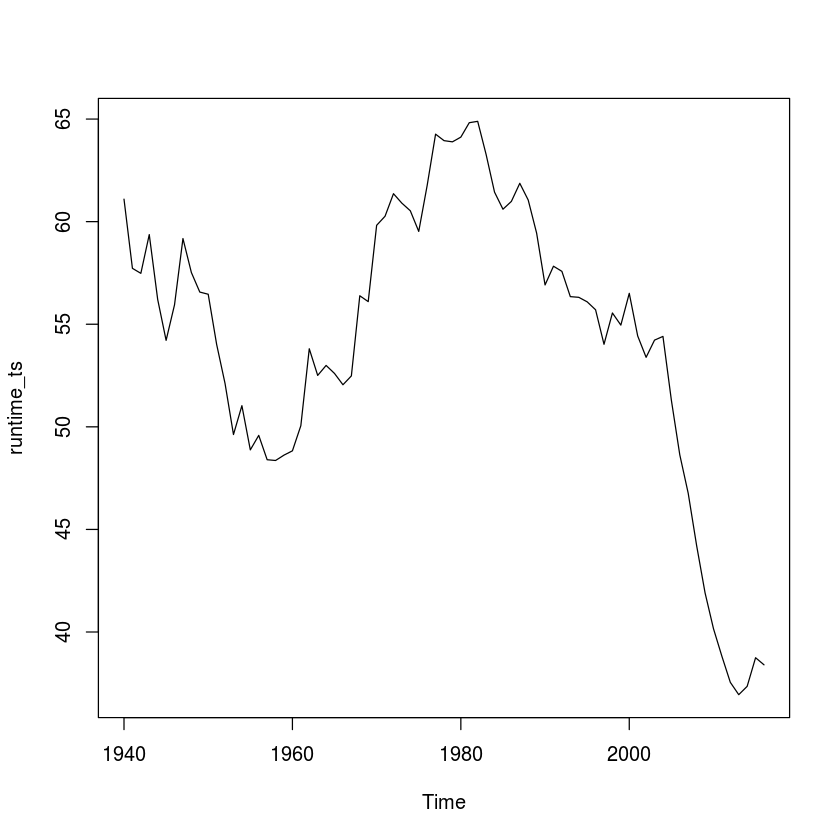

In [167]:
plot(runtime_ts)

Well that data may have many different types of titles including shorts, etc

Let's first subset for movies

In [172]:
query = "SELECT avg(runtimeminutes) runtimeminutes, startyear 
            FROM title_basics
            WHERE titletype = 'movie'
            GROUP BY startyear
            ORDER BY startyear;"

av_runtime <- sqldf(query)

In [173]:
av_runtime

runtimeminutes,startyear
45.00000,1894
20.00000,1897
NA,1898
135.00000,1899
66.00000,1900
9.00000,1901
NA,1902
NA,1903
68.00000,1904
100.00000,1905


In [175]:
av_runtime_subset <- av_runtime[av_runtime$startyear %in% 1940:2016,]

av_runtime_subset

,runtimeminutes,startyear
45,84.25992,1940
46,86.25596,1941
47,85.38028,1942
48,84.55940,1943
49,84.80455,1944
50,84.85678,1945
51,85.32957,1946
52,86.37474,1947
53,86.72104,1948
54,88.14210,1949


In [176]:
runtime_ts <- ts(av_runtime_subset[[1]],
                 start = av_runtime_subset[1,2],
                 end = av_runtime_subset[nrow(av_runtime_subset),2])

runtime_ts

Time Series:
Start = 1940 
End = 2016 
Frequency = 1 
 [1] 84.25992 86.25596 85.38028 84.55940 84.80455 84.85678 85.32957 86.37474
 [9] 86.72104 88.14210 87.59634 89.07342 88.67294 89.38712 92.05054 92.07099
[17] 91.30238 90.12435 90.59342 91.75738 90.30726 89.30161 90.99763 90.17818
[25] 91.18553 93.31792 92.69657 95.31474 94.71499 91.53991 91.70942 89.61671
[33] 90.48318 89.86605 90.60441 90.09050 90.63739 92.32068 91.24928 90.90727
[41] 91.45959 91.22627 91.75125 90.36928 90.63929 91.64152 90.49673 94.04279
[49] 92.00481 92.52280 91.37899 91.89749 91.65210 91.53488 90.77124 90.53604
[57] 91.11044 90.26044 89.35724 90.90203 90.14773 89.95131 90.72581 89.47469
[65] 91.14913 88.40034 88.63699 88.33691 87.35872 85.57049 85.09991 86.19690
[73] 84.49878 84.67783 84.06408 85.16231 84.93204

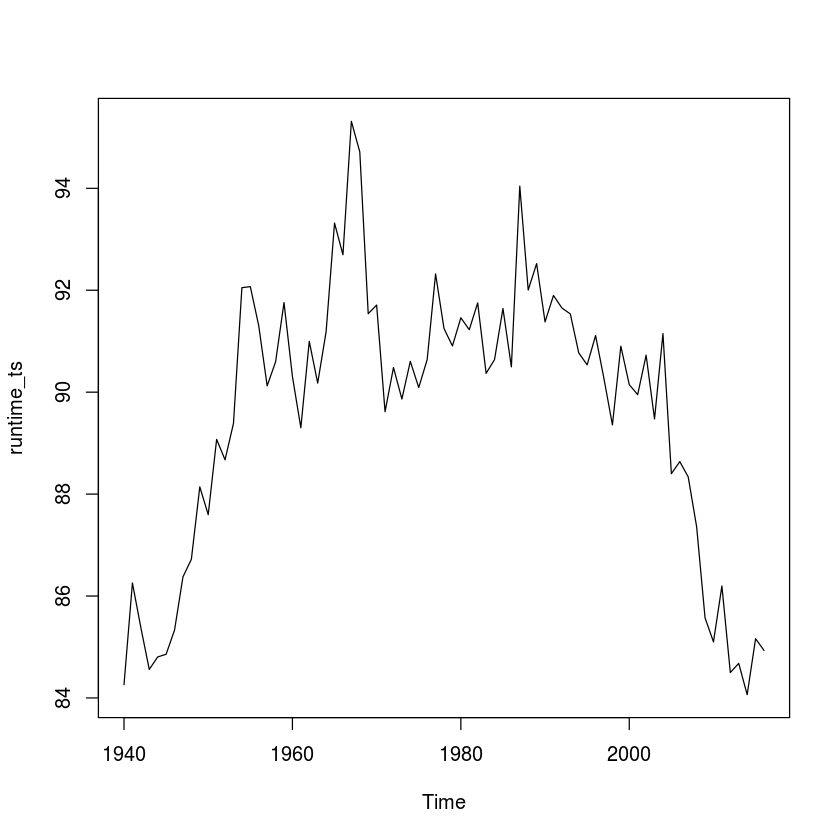

In [177]:
plot(runtime_ts)